In [1]:
from phantasy import MachinePortal
import numpy as np
from numpy import linalg as LA
import pandas as pd
import matplotlib.pyplot as plt
import time

# Set Up

The following uses an FRIB-like lattice to model the accelerator using FLAME, an envelope solver. I will access the BPMs and correctors using FIBR_VA. The following is just setting up the getters and setters.

In [2]:
mp = MachinePortal('FRIB_VA', 'LS1FS1')
lat = mp.work_lattice_conf

[15:01:49.175] INFO: phantasy.library.operation.core: Load new machine: 'FRIB_VA', segment: 'LS1FS1'
[15:01:49.176] INFO: phantasy.library.parser.config: Importing FRIB_VA from /usr/lib/phantasy-machines/FRIB_VA
[15:01:49.180] INFO: phantasy.library.parser.config: Loading machine configuration from /usr/lib/phantasy-machines/FRIB_VA/phantasy.ini
[15:01:49.182] INFO: phantasy.library.operation.lattice: Loading segment: 'LS1FS1'
[15:01:49.192] WARNING: phantasy.library.operation.lattice: Default UNICORN policy will be applied.
[15:01:49.193] WARNING: phantasy.library.operation.lattice: No aligment data is read.
[15:01:49.194] WARNING: phantasy.library.operation.lattice: Default device polarity will be applied.
[15:01:49.195] INFO: phantasy.library.operation.lattice: Loading PV data from CSV/SQLite: /usr/lib/phantasy-machines/FRIB_VA/ls1fs1/channels.csv
[15:01:49.199] INFO: phantasy.library.pv.datasource: Set source to be CSV table: channels.csv.
[15:01:49.381] INFO: phantasy.library.oper

[15:01:50.311] WARNING: phantasy.library.lattice.lattice: LS1_CB11:DCV_D1892 is not in layout.
[15:01:50.312] WARNING: phantasy.library.lattice.lattice: LS1_CB11:DCH_D1892 is not in layout.
[15:01:50.312] WARNING: phantasy.library.lattice.lattice: LS1_CB11:DCV_D1912 is not in layout.
[15:01:50.313] WARNING: phantasy.library.lattice.lattice: LS1_CB11:DCH_D1912 is not in layout.
[15:01:50.313] WARNING: phantasy.library.lattice.lattice: LS1_BTS:DCV_D1937 is not in layout.
[15:01:50.314] WARNING: phantasy.library.lattice.lattice: LS1_BTS:DCH_D1937 is not in layout.
[15:01:50.314] WARNING: phantasy.library.lattice.lattice: LS1_BTS:DCV_D1964 is not in layout.
[15:01:50.315] WARNING: phantasy.library.lattice.lattice: LS1_BTS:DCH_D1964 is not in layout.
[15:01:50.315] WARNING: phantasy.library.lattice.lattice: LS1_BTS:DCV_D1997 is not in layout.
[15:01:50.316] WARNING: phantasy.library.lattice.lattice: LS1_BTS:DCH_D1997 is not in layout.
[15:01:50.316] WARNING: phantasy.library.lattice.lattice

In [3]:
all_bpms = mp.get_elements(type='BPM')  # get each bmps
all_vcors = mp.get_elements(type='VCOR')  # get each vertical correctors
all_hcors = mp.get_elements(type='HCOR')  # get each horizontal correctors

In [4]:
def get_vcor():
    name = [i.name for i in all_vcors]
    x1 = [i.I for i in all_vcors]
    x2 = [i.TM for i in all_vcors]
    x3 = [i.sb for i in all_vcors]
    vcor = pd.DataFrame({"name":name,
                         "current":x1,
                        "TM":x2,
                        "position":x3})
    return vcor
def get_hcor():  
    name = [i.name for i in all_hcors]
    x1 = [i.I for i in all_hcors]
    x2 = [i.TM for i in all_hcors]
    x3 = [i.sb for i in all_hcors]
    hcor = pd.DataFrame({"name":name,
                         "current":x1,
                        "TM":x2,
                        "position":x3})
    return hcor
def get_bpm():
    name = [i.name for i in all_bpms]
    x1 = [i.X for i in all_bpms]
    x2 = [i.XPOS for i in all_bpms]
    x3 = [i.Y for i in all_bpms]
    x4 = [i.YPOS for i in all_bpms]
    x5 = [i.PHA for i in all_bpms]
    x6 = [i.PHASE for i in all_bpms]
    x7 = [i.ENG for i in all_bpms]
    x8 = [i.ENERGY for i in all_bpms]
    x9 = [i.sb for i in all_bpms]
    bpm = pd.DataFrame({"name":name,
                          "X":x1,
                          "XPOS":x2,
                          "Y":x3,
                          "YPOS":x4,
                           "PHA":x5,
                          "PHASE":x6,
                          "ENG":x7,
                          "ENERGY":x8,
                       "position":x9})
    return bpm

In [5]:
def update_hcors(index, value):
    """
    Updates hcors one at a time
    """
    all_hcors[index].I = value
    lat.sync_settings()
    latfile, fm_online = lat.run()

In [6]:
def getxy(element, x,y):
    """
    Given beam element "element", it returns both fields "X" and "Y".
    """
    return (np.array(element[x].values),np.array(element[y].values))

# Creating the Orbital Response Matrix (ORM)

WIll first create the matrix were the error on the VA was manually set to 0.00%

[15:01:50.527] WARNING: phantasy.library.lattice.element: FS1_CSS:DCH_D2381 [I] is read only.
[15:01:50.528] WARNING: phantasy.library.lattice.element: FS1_BBS:DCH_D2412 [I] is read only.
[15:01:50.536] WARNING: phantasy.library.lattice.element: FS1_BBS:DCH_D2476 [I] is read only.
[15:01:50.537] WARNING: phantasy.library.lattice.element: FS1_BMS:DCH_D2507 [I] is read only.
[15:01:50.538] WARNING: phantasy.library.lattice.element: FS1_BMS:DCH_D2534 [I] is read only.
[15:01:50.544] WARNING: phantasy.library.lattice.element: FS1_BMS:DCH_D2584 [I] is read only.
[15:01:50.545] WARNING: phantasy.library.lattice.element: FS1_BMS:DCH_D2640 [I] is read only.
[15:01:50.548] WARNING: phantasy.library.lattice.element: FS1_BMS:DCH_D2662 [I] is read only.
[15:01:50.549] WARNING: phantasy.library.lattice.element: FS1_BMS:DCH_D2688 [I] is read only.
[15:01:50.550] INFO: phantasy.library.lattice.lattice: Sync settings from 'control' to 'model'.
[15:01:51.252] ERROR: flame_utils.core.model: expected str

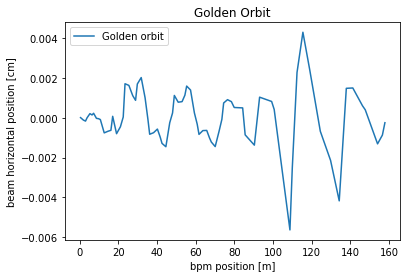

In [7]:
ORM = np.zeros((len(all_bpms),len(all_hcors))) # (75,60)
# Set all correctos to 0 so we'll have a fresh start
for el in all_hcors:
    el.I=0
# sync settings
lat.sync_settings()
latfile, fm_online = lat.run()

x_bpm, y_bpm = getxy(get_bpm(), "position", "X")
plt.plot(x_bpm,y_bpm, label = 'Golden orbit')
plt.legend()
plt.xlabel('bpm position [m]')
plt.ylabel('beam horizontal position [cm]')
plt.title('Golden Orbit')
plt.savefig('GO.png', dpi=300)

# Get current positions and corrector's value so we don't mess up the machine
_, b0 = getxy(get_bpm(), "position", "X")
_, h0 = getxy(get_hcor(), "position", "current")

In [8]:
for i in range(len(all_hcors)):
    update_hcors(i, h0[i]+0.00005)
    time.sleep(3.0)
    _, b1 = getxy(get_bpm(), "position", "X")
    update_hcors(i, h0[i]-0.00005)
    time.sleep(3.0)
    _, b2 = getxy(get_bpm(), "position", "X")
    update_hcors(i, h0[i])
    deltab = b1-b2
    deltah = .0001
    ORM[:,i] = deltab/deltah

[15:01:52.932] INFO: phantasy.library.lattice.lattice: Sync settings from 'control' to 'model'.
[15:01:53.637] ERROR: flame_utils.core.model: expected str, bytes or os.PathLike object, not NoneType
[15:01:53.641] WARNING: flame_utils.core.model: ModelFlame: Lattice file is not valid, do it manually.
[15:01:57.449] INFO: phantasy.library.lattice.lattice: Sync settings from 'control' to 'model'.
[15:01:58.083] ERROR: flame_utils.core.model: expected str, bytes or os.PathLike object, not NoneType
[15:01:58.084] WARNING: flame_utils.core.model: ModelFlame: Lattice file is not valid, do it manually.
[15:02:01.870] INFO: phantasy.library.lattice.lattice: Sync settings from 'control' to 'model'.
[15:02:02.498] ERROR: flame_utils.core.model: expected str, bytes or os.PathLike object, not NoneType
[15:02:02.499] WARNING: flame_utils.core.model: ModelFlame: Lattice file is not valid, do it manually.
[15:02:02.959] INFO: phantasy.library.lattice.lattice: Sync settings from 'control' to 'model'.
[

[15:03:24.176] ERROR: flame_utils.core.model: expected str, bytes or os.PathLike object, not NoneType
[15:03:24.177] WARNING: flame_utils.core.model: ModelFlame: Lattice file is not valid, do it manually.
[15:03:27.963] INFO: phantasy.library.lattice.lattice: Sync settings from 'control' to 'model'.
[15:03:28.607] ERROR: flame_utils.core.model: expected str, bytes or os.PathLike object, not NoneType
[15:03:28.608] WARNING: flame_utils.core.model: ModelFlame: Lattice file is not valid, do it manually.
[15:03:32.393] INFO: phantasy.library.lattice.lattice: Sync settings from 'control' to 'model'.
[15:03:33.084] ERROR: flame_utils.core.model: expected str, bytes or os.PathLike object, not NoneType
[15:03:33.086] WARNING: flame_utils.core.model: ModelFlame: Lattice file is not valid, do it manually.
[15:03:33.679] INFO: phantasy.library.lattice.lattice: Sync settings from 'control' to 'model'.
[15:03:34.292] ERROR: flame_utils.core.model: expected str, bytes or os.PathLike object, not None

[15:04:57.392] WARNING: flame_utils.core.model: ModelFlame: Lattice file is not valid, do it manually.
[15:05:01.199] INFO: phantasy.library.lattice.lattice: Sync settings from 'control' to 'model'.
[15:05:02.095] ERROR: flame_utils.core.model: expected str, bytes or os.PathLike object, not NoneType
[15:05:02.097] WARNING: flame_utils.core.model: ModelFlame: Lattice file is not valid, do it manually.
[15:05:05.958] INFO: phantasy.library.lattice.lattice: Sync settings from 'control' to 'model'.
[15:05:06.613] ERROR: flame_utils.core.model: expected str, bytes or os.PathLike object, not NoneType
[15:05:06.616] WARNING: flame_utils.core.model: ModelFlame: Lattice file is not valid, do it manually.
[15:05:07.136] INFO: phantasy.library.lattice.lattice: Sync settings from 'control' to 'model'.
[15:05:07.866] ERROR: flame_utils.core.model: expected str, bytes or os.PathLike object, not NoneType
[15:05:07.867] WARNING: flame_utils.core.model: ModelFlame: Lattice file is not valid, do it manu

[15:06:31.368] INFO: phantasy.library.lattice.lattice: Sync settings from 'control' to 'model'.
[15:06:32.015] ERROR: flame_utils.core.model: expected str, bytes or os.PathLike object, not NoneType
[15:06:32.017] WARNING: flame_utils.core.model: ModelFlame: Lattice file is not valid, do it manually.
[15:06:35.876] INFO: phantasy.library.lattice.lattice: Sync settings from 'control' to 'model'.
[15:06:36.533] ERROR: flame_utils.core.model: expected str, bytes or os.PathLike object, not NoneType
[15:06:36.534] WARNING: flame_utils.core.model: ModelFlame: Lattice file is not valid, do it manually.
[15:06:37.002] INFO: phantasy.library.lattice.lattice: Sync settings from 'control' to 'model'.
[15:06:37.596] ERROR: flame_utils.core.model: expected str, bytes or os.PathLike object, not NoneType
[15:06:37.597] WARNING: flame_utils.core.model: ModelFlame: Lattice file is not valid, do it manually.
[15:06:41.415] INFO: phantasy.library.lattice.lattice: Sync settings from 'control' to 'model'.
[

[15:08:03.922] ERROR: flame_utils.core.model: expected str, bytes or os.PathLike object, not NoneType
[15:08:03.923] WARNING: flame_utils.core.model: ModelFlame: Lattice file is not valid, do it manually.
[15:08:07.751] INFO: phantasy.library.lattice.lattice: Sync settings from 'control' to 'model'.
[15:08:08.368] ERROR: flame_utils.core.model: expected str, bytes or os.PathLike object, not NoneType
[15:08:08.369] WARNING: flame_utils.core.model: ModelFlame: Lattice file is not valid, do it manually.
[15:08:08.850] INFO: phantasy.library.lattice.lattice: Sync settings from 'control' to 'model'.
[15:08:09.304] ERROR: flame_utils.core.model: expected str, bytes or os.PathLike object, not NoneType
[15:08:09.305] WARNING: flame_utils.core.model: ModelFlame: Lattice file is not valid, do it manually.
[15:08:13.087] INFO: phantasy.library.lattice.lattice: Sync settings from 'control' to 'model'.
[15:08:13.680] ERROR: flame_utils.core.model: expected str, bytes or os.PathLike object, not None

[15:09:37.394] WARNING: flame_utils.core.model: ModelFlame: Lattice file is not valid, do it manually.
[15:09:41.255] INFO: phantasy.library.lattice.lattice: Sync settings from 'control' to 'model'.
[15:09:41.963] ERROR: flame_utils.core.model: expected str, bytes or os.PathLike object, not NoneType
[15:09:41.964] WARNING: flame_utils.core.model: ModelFlame: Lattice file is not valid, do it manually.
[15:09:42.574] INFO: phantasy.library.lattice.lattice: Sync settings from 'control' to 'model'.
[15:09:43.274] ERROR: flame_utils.core.model: expected str, bytes or os.PathLike object, not NoneType
[15:09:43.275] WARNING: flame_utils.core.model: ModelFlame: Lattice file is not valid, do it manually.
[15:09:47.146] INFO: phantasy.library.lattice.lattice: Sync settings from 'control' to 'model'.
[15:09:47.764] ERROR: flame_utils.core.model: expected str, bytes or os.PathLike object, not NoneType
[15:09:47.765] WARNING: flame_utils.core.model: ModelFlame: Lattice file is not valid, do it manu

[15:11:13.176] INFO: phantasy.library.lattice.lattice: Sync settings from 'control' to 'model'.
[15:11:13.859] ERROR: flame_utils.core.model: expected str, bytes or os.PathLike object, not NoneType
[15:11:13.860] WARNING: flame_utils.core.model: ModelFlame: Lattice file is not valid, do it manually.
[15:11:14.364] INFO: phantasy.library.lattice.lattice: Sync settings from 'control' to 'model'.
[15:11:14.985] ERROR: flame_utils.core.model: expected str, bytes or os.PathLike object, not NoneType
[15:11:14.986] WARNING: flame_utils.core.model: ModelFlame: Lattice file is not valid, do it manually.
[15:11:18.873] INFO: phantasy.library.lattice.lattice: Sync settings from 'control' to 'model'.
[15:11:19.588] ERROR: flame_utils.core.model: expected str, bytes or os.PathLike object, not NoneType
[15:11:19.589] WARNING: flame_utils.core.model: ModelFlame: Lattice file is not valid, do it manually.
[15:11:23.391] INFO: phantasy.library.lattice.lattice: Sync settings from 'control' to 'model'.
[

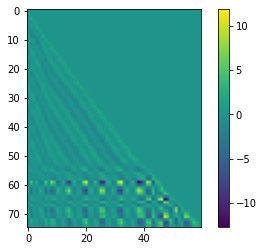

In [9]:
plt.imshow(ORM)
plt.colorbar()
plt.savefig("ORM.png", dpi=300)

# Trying Different Inverses

and calculating the error from each inverse.

In [10]:
def SVD(M):
    """
    Calculate Standard Value Decomposition using direct method.
    """
    w,v = LA.eig(M.T@M)
    mask = np.argsort(w)
    mask = mask[::-1]
    w = w[mask]
    v = v[:,mask] 
    sigma = np.sqrt(np.abs(w))
    Sigma = np.zeros(M.shape)
    SigmaInv = np.zeros(M.shape[::-1])
    for i in range(np.min(Sigma.shape)):
        Sigma[i,i] = sigma[i]
        SigmaInv[i,i] = 1/sigma[i] 
    u = M@v@SigmaInv
    return u,sigma,np.conj(v.T)

def getInvSVD(M):
    """
    Calculate the inverse of the SVD by first creating the inverse of the
    sigma matrix directly, then multiply by V and U accordingly.
    """
    U,S,VT = SVD(M)
    shape = M.shape
    S_ = np.zeros((shape[::-1]))
    for i in range(np.min(M.shape)):
        S_[i,i] = 1/S[i]
    return np.real(np.conj(VT.T)@S_@np.conj(U.T))
  
def mgs(A):
    """Modified Gram-Schmidt algorithm"""
    m = np.shape(A)[0]
    n = np.shape(A)[1]
    Q =  np.zeros((m, n))
    R =  np.zeros((n, n)) 
    for j in range(n):
        v = A[:,j]
        for i in range(j):
            R[i,j] = np.dot(Q[:,i].T,A[:,j])
            v = v - np.dot(Q[:,i],R[i,j])
        R[j,j] =  np.linalg.norm(v)
        Q[:,j] = (v/R[j,j])
    return Q,R

def getQRpinv(A):
    """Get psuedo-inverse from QR"""
    Q,R = mgs(A.T@A)
    return LA.inv(R)@Q.T@A.T

def getQRinv(A):
    """Get inverse from QR"""
    Q,R = mgs(A)
    return LA.inv(R)@Q.T

def choleskyD(A):
    """Cholesky Decomposition"""
    n = A.shape[0]
    L = np.zeros((n, n), dtype=np.double)
    for i in range(n):
        for k in range(i+1):
            tmp_sum = sum(L[i][j] * L[k][j] for j in range(k))
            if (i == k): 
                L[i][k] = np.sqrt(np.real(A[i][i] - tmp_sum))
            else:
                L[i][k] = (1.0 / L[k][k] * (A[i][k] - tmp_sum))
    return L

def cholesky(A):
    """Get psuedo-inverse from Cholesky"""
    L = choleskyD(A.T@A)
    return LA.inv(L@L.T)@A.T

def LU(H):  # Actually works for nxm as well
    """
    Implementation of LU factorization
    """
    m = H.shape[0]
    n = H.shape[1]
    L = np.eye(m)
    U = np.matrix.copy(H)
    for k in range(n-1):
        for j in range(k+1,m):
            L[j,k] = U[j,k]/U[k,k]
            U[j,k:] = U[j,k:] - L[j,k]*U[k,k:]
    return L,U

def LUP(H):  # Add pivoting for stability
    """
    Implementation of LU factorization with pivoting.
    Assume square matrix else,
    Assumes first index is less than second index. m<n
    so doesn't work on all rectangular matrices
    """
    m = H.shape[0]
    n = H.shape[1]
    L = np.eye(m)
    P = np.eye(m)
    U = np.matrix.copy(H)
    for k in range(m-1): # to right
        tempU = U[k:,k]
        max_index = np.argmax(tempU)+k
        U[[k,max_index],k:] = U[[max_index,k],k:] # switch rows
        L[[k,max_index],:k] = L[[max_index,k],:k] # switch rows
        P[[k,max_index],:] = P[[max_index,k],:] # switch rows
        for j in range(k+1,m): # go down
            L[j,k] = U[j,k]/U[k,k]
            U[j,k:] = U[j,k:] - L[j,k]*U[k,k:]
    return L,U,P

def getLUPpinv(H):
    """Get psuedo-inverse from LUP"""
    L,U,P = LUP(H.T@H)
    return LA.inv(U)@LA.inv(L)@P@H.T

def getLUPinv(H):
    """Get inverse from LUP"""
    L,U,P = LUP(H)
    return LA.inv(U)@LA.inv(L)@P

def iterStep(A,X):
    return X@(2*np.eye(A.shape[0])-A@X)

def BIinv(A, n, error = 1e-10):
    X = 1/2000*A.T
    for _ in range(n):
        if (np.abs((X@A) - np.eye(np.min(A.shape)))).sum() < error:
            return X
        X = iterStep(A,X)
    return X

iter = 100

In [11]:
# Calculate the inverse and also time it
%timeit ORM_inv_SVD = getInvSVD(ORM)
%timeit ORM_inv_QR = getQRpinv(ORM)
%timeit ORM_inv_cholesky = cholesky(ORM)
%timeit ORM_inv_LUP = getLUPpinv(ORM)
%timeit ORM_inv_BI = BIinv(ORM, 100)
%timeit ORM_inv = LA.pinv(ORM)

3.38 ms ± 127 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
22.4 ms ± 1.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
88.8 ms ± 2.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
18.9 ms ± 249 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<ipython-input-10-b230b340a858>:122: RuntimeWarning: overflow encountered in matmul
  return X@(2*np.eye(A.shape[0])-A@X)
<ipython-input-10-b230b340a858>:127: RuntimeWarning: invalid value encountered in matmul
  if (np.abs((X@A) - np.eye(np.min(A.shape)))).sum() < error:
<ipython-input-10-b230b340a858>:122: RuntimeWarning: invalid value encountered in matmul
  return X@(2*np.eye(A.shape[0])-A@X)


74.3 ms ± 1.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.08 ms ± 25.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
ORM_inv_SVD = getInvSVD(ORM)
ORM_inv_QR = getQRpinv(ORM)
ORM_inv_cholesky = cholesky(ORM)
ORM_inv_LUP = getLUPpinv(ORM)
ORM_inv_BI = BIinv(ORM, 100)
ORM_inv = LA.pinv(ORM)

<ipython-input-10-b230b340a858>:122: RuntimeWarning: overflow encountered in matmul
  return X@(2*np.eye(A.shape[0])-A@X)
<ipython-input-10-b230b340a858>:127: RuntimeWarning: invalid value encountered in matmul
  if (np.abs((X@A) - np.eye(np.min(A.shape)))).sum() < error:
<ipython-input-10-b230b340a858>:122: RuntimeWarning: invalid value encountered in matmul
  return X@(2*np.eye(A.shape[0])-A@X)


In [15]:
def InvError(A,B):
  """
  A : Left matrix
  B : Right matrix
  """
  return np.abs(np.eye(np.min(A.shape[0:2])) - A@B).sum()

In [17]:
print(f"Error of SVD method is {InvError(ORM_inv_SVD, ORM)}")
print(f"Error of QR method is {InvError(ORM_inv_QR, ORM)}")
print(f"Error of Cholesky method is {InvError(ORM_inv_cholesky, ORM)}")
print(f"Error of LUP method is {InvError(ORM_inv_LUP, ORM)}")
print(f"Error of Ben-Israel method is {InvError(ORM_inv_BI, ORM)}")
print(f"Error of Numpy method is {InvError(ORM_inv, ORM)}")

Error of SVD method is 7.016723720395459e-10
Error of QR method is 28029.307788148908
Error of Cholesky method is 2.7213080175136224e-08
Error of LUP method is 830949.5486645361
Error of Ben-Israel method is nan
Error of Numpy method is 2.3685441167598593e-12


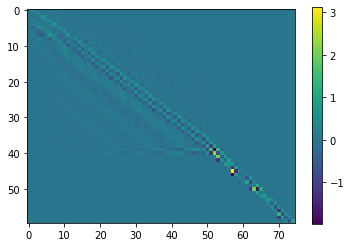

In [18]:
plt.imshow(ORM_inv_SVD)
plt.colorbar()
plt.savefig("inv_ORM.png", dpi=300)

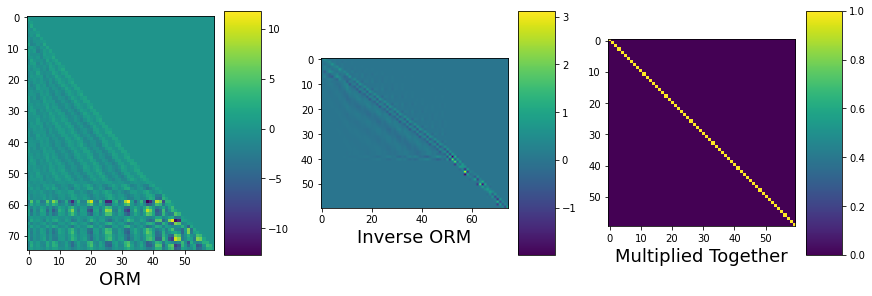

In [78]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(12, 4),
                        constrained_layout=True)
c1=axs[0].imshow(ORM)
axs[0].set_xlabel("ORM", fontsize=18)
c2=axs[1].imshow(ORM_inv_SVD)
axs[1].set_xlabel("Inverse ORM", fontsize=18)
c3=axs[2].imshow(ORM_inv_SVD@ORM)
axs[2].set_xlabel("Multiplied Together", fontsize=18)
fig.colorbar(c1, ax=axs[0])
fig.colorbar(c2,ax=axs[1])
fig.colorbar(c3,ax=axs[2])
plt.savefig("ORMs.png", dpi=300, bbox_inches = "tight")

Looking at the accuracy, only SVD and Cholesky are resonable. Then looking at the time to calculate the inverses, SVD is the fastest. SVD is the best choice as it has the fastest calculation time and also the best accuracy.

# Beam Correction

In [79]:
for el in all_hcors:
    el.I=0
lat.sync_settings()
latfile, fm_online = lat.run()

_, b0 = getxy(get_bpm(), "position", "X")  # golden orbit we want to keep

[15:50:40.500] INFO: phantasy.library.lattice.lattice: Sync settings from 'control' to 'model'.
[15:50:41.235] ERROR: flame_utils.core.model: expected str, bytes or os.PathLike object, not NoneType
[15:50:41.236] WARNING: flame_utils.core.model: ModelFlame: Lattice file is not valid, do it manually.


MSE on golden orbit before adding noise to correctors: 0.0006287740371943867


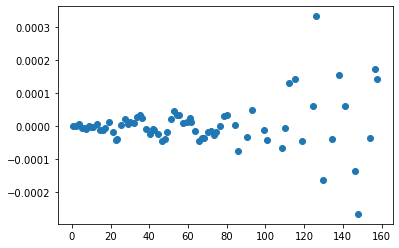

In [80]:
x_bpm, y_bpm = getxy(get_bpm(), "position", "X")
plt.scatter(x_bpm,y_bpm - b0)  # error from golden orbit
print(f"MSE on golden orbit before adding noise to correctors: {np.sqrt(((y_bpm - b0)**2).sum())}")

In [81]:
# Add random noise to the correctors
for el in all_hcors[0:60]:
    el.I = (np.random.rand(1)-.5)*.0005

lat.sync_settings()
latfile, fm_online = lat.run()
time.sleep(3.0) 

[15:50:42.909] INFO: phantasy.library.lattice.lattice: Sync settings from 'control' to 'model'.
[15:50:43.634] ERROR: flame_utils.core.model: expected str, bytes or os.PathLike object, not NoneType
[15:50:43.635] WARNING: flame_utils.core.model: ModelFlame: Lattice file is not valid, do it manually.


MSE on golden orbit after adding noise to correctors: 0.006667001353107803


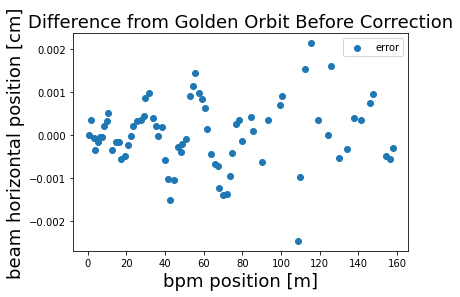

In [82]:
x_bpm, y_bpm = getxy(get_bpm(), "position", "X")
plt.scatter(x_bpm,y_bpm - b0, label='error')  # error from golden orbit
print(f"MSE on golden orbit after adding noise to correctors: {np.sqrt(((y_bpm - b0)**2).sum())}")
plt.legend()
plt.xlabel('bpm position [m]', fontsize=18)
plt.ylabel('beam horizontal position [cm]', fontsize=18)
plt.title('Difference from Golden Orbit Before Correction', fontsize=18)
plt.savefig('Error.png', dpi=300, bbox_inches = "tight")

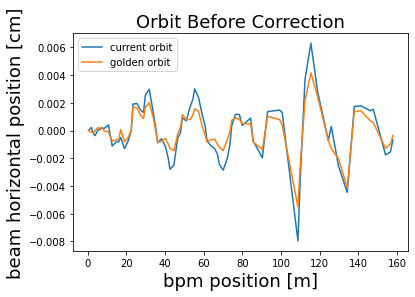

In [83]:
plt.plot(x_bpm,y_bpm, label = 'current orbit')
plt.plot(x_bpm,b0, label = 'golden orbit')
plt.legend()
plt.xlabel('bpm position [m]', fontsize=18)
plt.ylabel('beam horizontal position [cm]', fontsize=18)
plt.title('Orbit Before Correction', fontsize=18)
plt.savefig('before.png', dpi=300, bbox_inches = "tight")

In [84]:
def do_correction(b0, ORM_):
    """
    b0 - golden orbit
    ORM - inverse of ROM matrix
    
    return: MSU from golden orbit
    """
    # We want the change bpm position back to the golden orbit so we want the following corrections to the orbit.
    x_bpm, y_bpm = getxy(get_bpm(), "position", "X")  # get current positions
    dx = b0 - y_bpm # get changes we want

    correctorh = ORM_@(dx)  # get corrector settings for those changes. Use pseudo-inverse from SVD

    for i in range(len(all_hcors)):  # put in those changes
        all_hcors[i].I = all_hcors[i].I + correctorh[i]

    lat.sync_settings()  # put into machine
    latfile, fm_online = lat.run()

    time.sleep(3.0)  # sleep on it to let it update

    x_bpm, y_bpm = getxy(get_bpm(), "position", "X") # get new positions
    return np.sqrt(((y_bpm - b0)**2).sum())

In [85]:
mse = do_correction(b0, ORM_inv_SVD)
print(f"error from golden orbit {mse}")  # get error

[15:51:37.400] INFO: phantasy.library.lattice.lattice: Sync settings from 'control' to 'model'.
[15:51:38.445] ERROR: flame_utils.core.model: expected str, bytes or os.PathLike object, not NoneType
[15:51:38.452] WARNING: flame_utils.core.model: ModelFlame: Lattice file is not valid, do it manually.


error from golden orbit 0.0002109608418700968


MSE on golden orbit after correction: 0.0004380175303351529


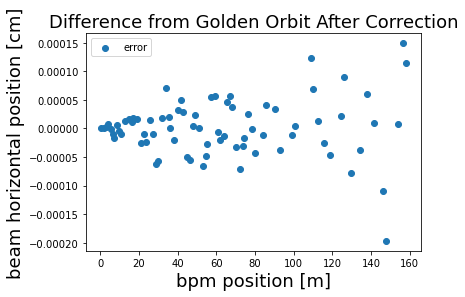

In [86]:
x_bpm, y_bpm = getxy(get_bpm(), "position", "X")
plt.scatter(x_bpm,y_bpm - b0, label = 'error')  # error from golden orbit
print(f"MSE on golden orbit after correction: {np.sqrt(((y_bpm - b0)**2).sum())}")
plt.legend()
plt.xlabel('bpm position [m]', fontsize=18)
plt.ylabel('beam horizontal position [cm]', fontsize=18)
plt.title('Difference from Golden Orbit After Correction', fontsize=18)
plt.savefig('Error_.png', dpi=300, bbox_inches = "tight")

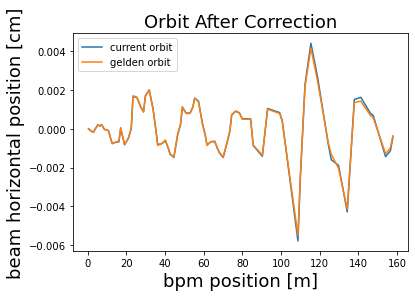

In [88]:
x_bpm, y_bpm = getxy(get_bpm(), "position", "X")
plt.plot(x_bpm,y_bpm, label = 'current orbit')
plt.plot(x_bpm,b0, label = 'gelden orbit')
plt.legend()
plt.xlabel('bpm position [m]', fontsize=18)
plt.ylabel('beam horizontal position [cm]', fontsize=18)
plt.title('Orbit After Correction', fontsize=18)
plt.savefig('after.png', dpi=300, bbox_inches = "tight")